# Table of Contents
 <p><div class="lev1 toc-item"><a href="#HIF-1-OH" data-toc-modified-id="HIF-1-OH-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>HIF-1-OH</a></div><div class="lev1 toc-item"><a href="#HIF-1" data-toc-modified-id="HIF-1-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>HIF-1</a></div><div class="lev1 toc-item"><a href="#Egl-9" data-toc-modified-id="Egl-9-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Egl-9</a></div><div class="lev1 toc-item"><a href="#Vhl-1" data-toc-modified-id="Vhl-1-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Vhl-1</a></div><div class="lev1 toc-item"><a href="#Core-Hypoxia-Response" data-toc-modified-id="Core-Hypoxia-Response-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Core Hypoxia Response</a></div>

In [439]:
# important stuff:
import os
import pandas as pd
import numpy as np

# stats
from scipy import stats as sts

# morgan
import morgan as morgan
import tissue_enrichment_analysis as tea

# network graphics
import networkx as nx

# Graphics
import matplotlib as mpl
import matplotlib.ticker as plticker
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patheffects as path_effects
from matplotlib import rc
rc('text', usetex=True)

# bayes and mcmc
import pymc3 as pm
import theano

# Magic function to make matplotlib inline;
# other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline. 
# There is a bug, so uncomment if it works.
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

ft = 35 #title fontsize
import genpy
import gvars

In [17]:
q = 0.1

In [18]:
# Specify the genotypes to refer to:
single_mutants = ['b', 'c', 'd', 'e', 'g']
# Specify which genotypes are double mutants 
# and of what single mutants:
double_mutants = {'a' : 'bd', 'f':'bc'}

# initialize the morgan.hunt object:
# target_id is the column with isoform specific names
# b is the name of the column with the GLM regression coefficients
# tpm is the name of the column with the TPM numbers
# qval is the name of the column with the FDR corrected q-values
thomas = morgan.hunt('target_id', 'b', 'tpm', 'qval')

# input the genmap file:
thomas.add_genmap('../input/library_genotype_mapping.txt', comment='#')

# add the names of the single mutants
thomas.add_single_mutant(single_mutants)

# add the names of the double mutants
thomas.add_double_mutants(['a', 'f'], ['bd', 'bc'])

# set the q-value threshold for significance to its default value, 0.1
thomas.set_qval()

# Add the tpm files: 
kallisto_loc = '../input/kallisto_all/'
thomas.add_tpm(kallisto_loc, '/kallisto/abundance.tsv', '')

# load all the beta values for each genotype:
sleuth_loc = '../sleuth_all_adjusted/kallisto/'
for file in os.listdir("../sleuth_all_adjusted/kallisto"):
    if file[:4] == 'beta':
        letter = file[-5:-4].lower()
        thomas.add_beta(sleuth_loc + file, letter)
        thomas.beta[letter].sort_values('target_id', inplace=True)
        thomas.beta[letter].reset_index(inplace=True)

In [19]:
thomas.filter_data(0, 0.1)

Number of na genes: 232


In [440]:
genvar = gvars.genvars()

In [20]:
tissue_df = tea.fetch_dictionary()
phenotype_df = pd.read_csv('../input/phenotype_ontology.csv')
go_df = pd.read_csv('../input/go_dictionary.csv')

In [21]:
melted_tissue = pd.melt(tissue_df, id_vars='wbid', var_name='term', value_name='expressed')
melted_tissue = melted_tissue[melted_tissue.expressed == 1]

melted_phenotype = pd.melt(phenotype_df, id_vars='wbid', var_name='term', value_name='expressed')
melted_phenotype = melted_phenotype[melted_phenotype.expressed == 1]

melted_go = pd.melt(go_df, id_vars='wbid', var_name='term', value_name='expressed')
melted_go = melted_go[melted_go.expressed == 1]

In [162]:
frames = []
for key, df in thomas.beta.items():
    df['genotype'] = genvar.fancy_mapping[key]
    df['code'] = key
    df['abs_b'] = df.b.abs()
    frames += [df]

tidy_data = pd.concat(frames)

In [131]:
df1 = thomas.beta['f'].copy()
df2 = thomas.beta['c']
df3 = thomas.beta['e']
df4 = thomas.beta['b']
df5 = thomas.beta['a'] 
df6 = thomas.beta['d']

df1['b_c'] = df2.b
df1['b_e'] = df3.b
df1['b_b'] = df4.b
df1['b_a'] = df5.b
df1['b_d'] = df6.b

df1['se_b_c'] = df2.se_b
df1['se_b_e'] = df3.se_b
df1['se_b_b'] = df4.se_b
df1['se_b_a'] = df5.se_b
df1['se_b_d'] = df6.se_b

df1['q_c'] = df2.qval
df1['q_e'] = df3.qval
df1['q_b'] = df4.qval
df1['q_a'] = df5.qval
df1['q_d'] = df6.qval

In [339]:
# a qPCR barplot
def qPCR_plot(df, plotting, colors, **kwargs):
    """
    A function to make prettified qPCR barplots. 
    
    Takes as entry a dataframe as output by qPCR_prep method
    
    Params:
    df -- df as output by qPCR_prep
    plotting -- a dictionary of plotting order for each gene;
                keys must be in dataframe column 'plotting_group'
    colors -- color to be used for each gene
    kwargs -- clustering - the name of a column within the dataframe,
              bars grouped within the same cluster are given the same color;
              plotting_group - a string that must be a column within the
              dataframe, bars belonging to the same plotting group are 
              plotted adjacent to each other;
              alpha (transparency, float);
              q (stat. sig. thresh, float);
              save (string to save as)
              rotation;
              title
    
    outputs:
    a Seaborn barchart
    """
    clustering = kwargs.pop('clustering', 'ext_gene')
    plotting_group = kwargs.pop('plotting_group', 'genotype')
    alpha = kwargs.pop('alpha', 0.7)
    q = kwargs.pop('q', 0.1)
    save = kwargs.pop('save', '')
    rotation = kwargs.pop('rotation', 45)
    title = kwargs.pop('title', r'\emph{In Silico} qPCR')
    
    index = np.linspace(0, df[plotting_group].unique().shape[0]-1,
                        df[plotting_group].unique().shape[0])
    
    # error bars
    error_config = {'ecolor': '0.2'}

    # groupby gene name if it exists:
    grouped = df.groupby(clustering)
    
    bar_width = 1/(len(grouped)+1)
    
    # go through each gene
    for name, group in grouped:
        # figure out where each bar goes:
        if name not in plotting.keys():
            print(name, 'not in plotting.keys()')
            where = max(plotting.keys(),
                        key=lambda k: plotting[k])
            val = plotting[where]
            plotting[name] = val + 1
        
        add = plotting[name]*bar_width
        # figure out what color to give:
        if name in color.keys():
            # add the bar:
            barlist = plt.bar(index + add + bar_width/2, group.b.values,
                              bar_width, alpha=alpha,
                              yerr=group.se_b.values,
                              error_kw=error_config, label=name,
                              color=color[name])
        else:
            # add the bar but don't specify color
            barlist = plt.bar(index + add, group.b.values,
                              bar_width, alpha=alpha,
                              yerr=group.se_b.values,
                              error_kw=error_config, label=name)

        # significance threshold:
        sig = group.qval < q
        k = group[sig].order - 1

        # plot stars on top of stat. sig. results
        plt.plot(k + add + bar_width/2,
                 group[sig].b.values + group[sig].se_b.values + 0.05*group.b.max(),
                 r'*', color='k')
    
    # shade in every other bar group for clarity:
    grouped2 = df.groupby(plotting_group)
    k = 0
    col = '#CFCFCF'

    ymin, ymax = plt.gca().get_ylim()
    for name, group in grouped2:
        if k % 2 == 0:
            xmin = k - bar_width*0.5
            xmax = k + bar_width*(len(grouped) + 0.5)
            
            plt.fill_between([xmin, xmax], ymin, color=col)
            plt.fill_between([xmin, xmax], ymax, color=col)
        k += 1
    
    # fix the xlims and tick params etc...
    if (k - 1) % 2 == 0:
        plt.xlim(0, xmax)
    else:
        plt.xlim(0, plt.gca().get_xlim()[1] - 3/2*bar_width)

    plt.tick_params(axis='y',
                    which='major', labelsize=18)
    
    fancy_names = []
    for label in df[plotting_group].unique():
        genename = df[df[plotting_group] == label ].ens_gene.values[0]
        n_isoforms = df[df.ens_gene == genename].shape[0]/len(df.code.unique())
        if n_isoforms == 1:
            name = df[df[plotting_group] == label].ext_gene.values[0]
        else:
            name = label
        if r'\emph' not in name:
            fancy_names += [r'\emph{' + name + r'}']
        else:
            fancy_names += name

    plt.xticks(index + bar_width*len(df[clustering].unique())/2,
               fancy_names, rotation=rotation, fontsize=20)

    pathify(title, '',
            r'Regression Coefficient, $\beta$', )

    plt.legend(loc=(1.02, 0.5),fontsize=15)
    
    plt.ylim(ymin, ymax)
        
    if save:
        print('figure saved')
        plt.savefig(save, bbox_inches='tight')


plot_order = {r'\emph{egl-9;vhl-1}': 4,
              r'\emph{egl-9;hif-1}': 5,
              r'\emph{egl-9}': 1,
              r'\emph{hif-1}': 2,
              r'\emph{vhl-1}': 3,
              r'\emph{rhy-1}': 0
              }

color = {r'\emph{egl-9;vhl-1}':'#e41a1c',
              r'\emph{egl-9;hif-1}':'#377eb8',
              r'\emph{egl-9}': '#4daf4a',
              r'\emph{hif-1}': '#984ea3',
              r'\emph{vhl-1}': '#ff7f00',
              r'\emph{rhy-1}': '#ffff33'
              }

# HIF-1-OH

In [312]:
hifoh = pd.read_csv('../output/hifoh_regulation_candidates.csv')

# HIF-1

In [25]:
ind = (
       (df1.qval < 0.1) &
       (df1.q_c < 0.1)  &
       (df1.q_e < 0.1)  &
       (df1.q_b < 0.1)  &
       (df1.q_a < 0.1)  &
       (df1.q_d < 0.1)
      )
ind2 = ((df1.b_e > 0) &  # up in rhy
        (df1.b_b > 0) &  # up in egl
        (df1.b_a > 0) &  # up in eglvhl
        (df1.b_d > 0)    # up in vhl
       )
ind3 = ((df1.b < 0) &  # down in hif
       (df1.b_c < 0))  # down in egl/hif

df1[ind & ind2 & ind3][['ext_gene', 'b_e', 'q_e']].sort_values('q_e')

,ext_gene,b_e,q_e
19626,R08E5.3,4.577666,0.000000e+00
31611,nit-1,3.369282,4.598481e-32


We didn't get too many genes, so let's make the conditions less restrictive

In [328]:
sig =  ((df1.q_e < 0.1) &
        (df1.q_b < 0.1) &
        (df1.q_a < 0.1) &
        (df1.q_d < 0.1)
       )

up = ((df1.b_e > 0) &  # up in rhy
      (df1.b_b > 0) &  # up in egl
      (df1.b_a > 0) &  # up in eglvhl
      (df1.b_d > 0)    # up in vhl
     )

nochange = (
            ~(  # not (stat genes UP hif)
              (df1.q_c < 0.1) &
              (df1.b_c > 0)
             ) &
            ~(  # not (stat genes UP eglhif)
             (df1.qval < 0.1) &
             (df1.b > 0)
            )
            )

hypoxia_direct_targets = df1[sig & up & nochange].copy()
print(hypoxia_direct_targets.shape[0])
hypoxia_direct_targets[['ext_gene', 'b_e', 'q_e']].sort_values('q_e').head()
hypoxia_direct_targets.to_csv('../output/hypoxia_targets_candidates.csv', index=False)

133


In [320]:
ids = hypoxia_direct_targets.ens_gene.unique()
_ = tea.enrichment_analysis(ids, tissue_df, show=True)
_ = tea.enrichment_analysis(ids, phenotype_df, show=True)
_ = tea.enrichment_analysis(ids, go_df, show=False)

Executing script

                          Tissue  Expected  Observed  Enrichment Fold Change  \
90  coelomic system WBbt:0005749  5.910394        16                2.707095   

     P value   Q value  
90  0.000119  0.032602  
Executing script

                                         Tissue  Expected  Observed  \
80  oxygen response variant WBPhenotype:0000464  0.325218         4   

    Enrichment Fold Change  P value   Q value  
80               12.299444  0.00002  0.004965  


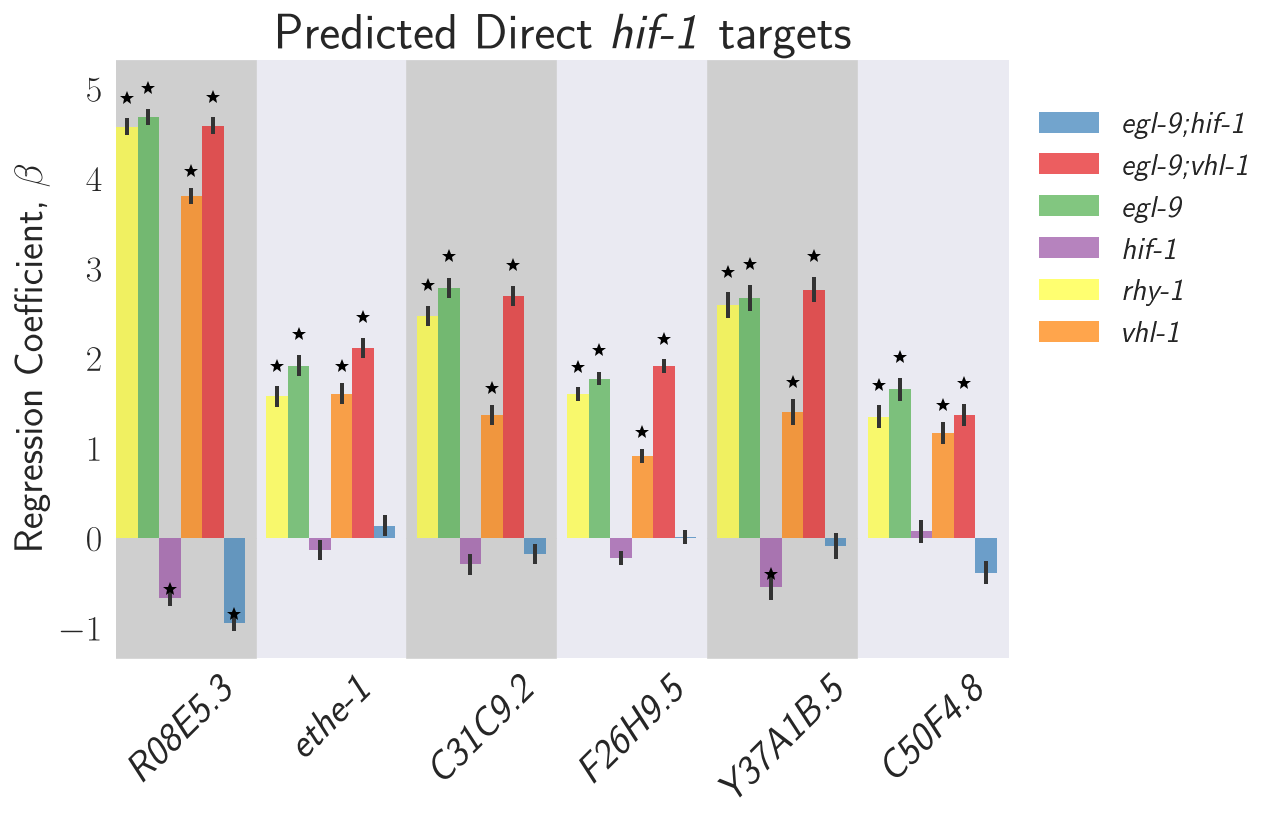

In [340]:
hypoxia_direct_targets['abs_mean_b'] = np.abs(1/4*(hypoxia_direct_targets.b_d + hypoxia_direct_targets.b_a
                                       + hypoxia_direct_targets.b_e + hypoxia_direct_targets.b_b))

hypoxia_direct_targets['abs_mean_q'] = np.abs(1/4*(hypoxia_direct_targets.q_d + hypoxia_direct_targets.q_a
                                       + hypoxia_direct_targets.q_e + hypoxia_direct_targets.q_b))

hypoxia_direct_targets.sort('abs_mean_q', inplace=True, ascending=True)
x = hypoxia_direct_targets.target_id

x_sort = {}
for i, xi in enumerate(x):
    x_sort[xi] = i + 1

tidy = tidy_data[(tidy_data.target_id.isin(hypoxia_direct_targets.target_id.values[:6])) &
                 (tidy_data.code != 'g')].copy()
tidy['order'] = tidy.target_id.map(x_sort)
tidy.sort_values('order', inplace=True)
tidy.reset_index(inplace=True)  
tidy = tidy[['target_id', 'ens_gene', 'ext_gene','b', 'se_b', 'qval', 'genotype', 'order', 'code']]

qPCR_plot(tidy, plot_order, color, clustering='genotype', plotting_group='target_id',
          title='Predicted Direct \emph{hif-1} targets', rotation=45)

# Egl-9

In [435]:
sig =    ((df1.qval < 0.1) &  # sig in eglhif
          (df1.q_c < 0.1))    # sig in hif

rhysig = ((df1.q_e < 0.1) & sig) # sig in rhy

eglsig = ((df1.q_b < 0.1) & sig) # sig in egl

# hif-1 causes rhy to go up, whereas eglhif has egl null, so effects
# should be opposite each other:
hif = (df1.b_c*df1.b < 0)    # opposite dir in hif/eglhif

# rhy and egl must be intact for egl to function:
rhy = (df1.b_e*df1.b > 0)  # same dir in rhy/eglhif

# rhy and egl must be intact for egl to function:
egl = (df1.b_b*df1.b > 0)    # same dir in egl/eglhif

# put the conditions together using OR logic:
sel = ((hif & egl & eglsig) | (hif & rhy & rhysig))
# sel = ((egl & eglsig) | (rhy & rhysig))

# find the targets
egl_targets = df1[sel].copy()

n = egl_targets.ens_gene.unique().shape[0]
print('There appear to be {0} egl-specific genes'.format(n))
egl_targets.to_csv('../output/egl_downstream.csv', index=False)

There appear to be 1 egl-specific genes


In [436]:
def pathify(title, xlabel, ylabel, xticks=True, yticks=True, **kwargs):
    """
    A function to pathify the labels, titles and ticks in a plot.
    """
    labelsize = kwargs.pop('labelsize', 20)
    titlesize = kwargs.pop('titlesize', 25)
    
    # make the labels and title into paths
    effect = [path_effects.Normal()]
    plt.ylabel(ylabel,
               fontsize=labelsize).set_path_effects(effect)
    plt.xlabel(xlabel,
               fontsize=labelsize).set_path_effects(effect)
    plt.title(title,
              fontsize=titlesize).set_path_effects(effect)

    ax = plt.gca()
    # go through each xtick or ytick and make 
    # it a path if user specified to do so.
    if xticks == True:
        for i, label in enumerate(ax.get_xticklabels()):
            ax.get_xticklabels()[i].set_path_effects(effect)
    if yticks == True:
        for i, label in enumerate(ax.get_yticklabels()):
            ax.get_yticklabels()[i].set_path_effects(effect)

In [437]:
egl_targets['avg_q'] = 1/6*(egl_targets.q_b + egl_targets.q_c + egl_targets.q_e + egl_targets.qval)
egl_targets.sort_values('avg_q', ascending=True)
x = egl_targets.target_id
x_sort = {}
for i, xi in enumerate(x):
    x_sort[xi] = i + 1

tidy = tidy_data[(tidy_data.target_id.isin(egl_targets.target_id[:10])) & (tidy_data.code != 'g')].copy()
tidy['order'] = tidy.target_id.map(x_sort)
tidy.sort_values('order', inplace=True)
tidy.reset_index(inplace=True)  
tidy = tidy[['target_id', 'ens_gene', 'ext_gene','b', 'se_b', 'qval', 'genotype', 'order', 'code']]

# x = df1[df1.ext_gene == 'nog-1'].target_id.values
# x_sort = {}
# for i, xi in enumerate(x):
#     x_sort[xi] = i + 1

# tidy = tidy_data[(tidy_data.ext_gene == 'nog-1') & (tidy_data.code != 'g')].copy()
# tidy['order'] = tidy.target_id.map(x_sort)
# tidy.sort_values('order', inplace=True)
# tidy.reset_index(inplace=True)  
# tidy = tidy[['target_id', 'ens_gene', 'ext_gene','b', 'se_b', 'qval', 'genotype', 'code', 'order']]

figure saved


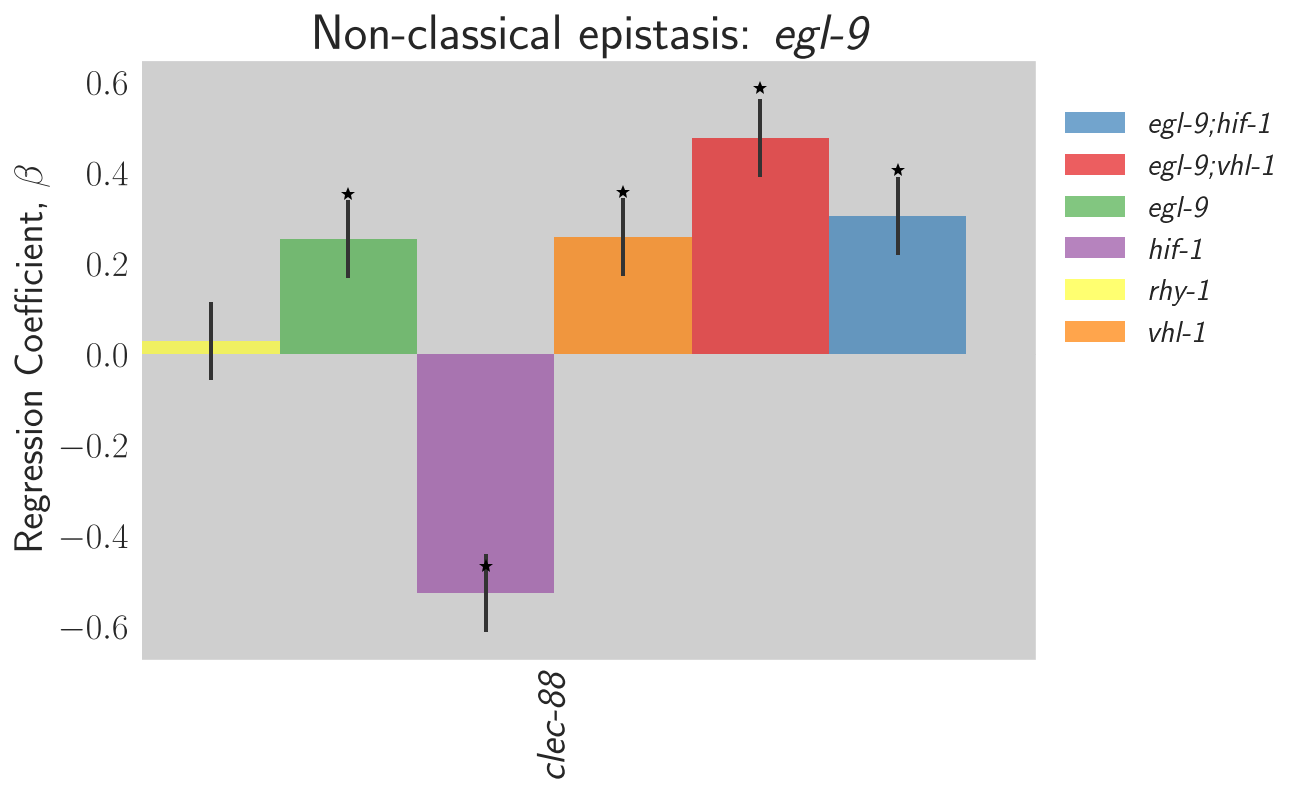

In [438]:
qPCR_plot(tidy, plot_order, color, clustering='genotype', plotting_group='target_id',
          title='Non-classical epistasis: \emph{egl-9}', rotation=90,
          save='Non-canonical epistasis_egl-9')

# Vhl-1

In [375]:
# should be statistically altered in vhl-1 mutants:
ind =  ((df1.q_a < 0.1) &  # sig in egl/vhl
        (df1.q_d < 0.1))  # sig in vhl

# should NOT b altered in egl-9, hif-1 or rhy-1 KO
ind2 = ((df1.q_e > 0.1) &  # rhy
        (df1.q_b > 0.1) &  # egl
        (df1.q_c > 0.1) &  # hif
        (df1.qval > 0.1))  # egl/hif

vhl_targets = df1[ind & ind2]
print(vhl_targets.shape[0])
# vhl_targets[['ext_gene', 'b_d', 'q_d', 'b_b', 'b_e']].sort_values('q_d').head(26)

36


In [353]:
ids = vhl_targets.ens_gene.unique()
_ = tea.enrichment_analysis(ids, tissue_df, show=True)
_ = tea.enrichment_analysis(ids, phenotype_df, show=True)
_ = tea.enrichment_analysis(ids, go_df, show=True)

Executing script

Analysis returned no enriched tissues.
Executing script

Analysis returned no enriched tissues.
Executing script

Analysis returned no enriched tissues.


In [354]:
vhl_targets['abs_mean_b'] = np.abs(1/2*(vhl_targets.b_d + vhl_targets.b_a))

vhl_targets.sort('abs_mean_b', inplace=True, ascending=False)
x = vhl_targets.target_id
x_sort = {}
for i, xi in enumerate(x):
    x_sort[xi] = i + 1

tidy = tidy_data[(tidy_data.target_id.isin(vhl_targets.target_id.values[:10])) & (tidy_data.code != 'g')].copy()
tidy['order'] = tidy.target_id.map(x_sort)
tidy.sort_values('order', inplace=True)
tidy.reset_index(inplace=True)  
tidy = tidy[['target_id', 'ens_gene', 'ext_gene','b', 'se_b', 'qval', 'genotype', 'order', 'code']]

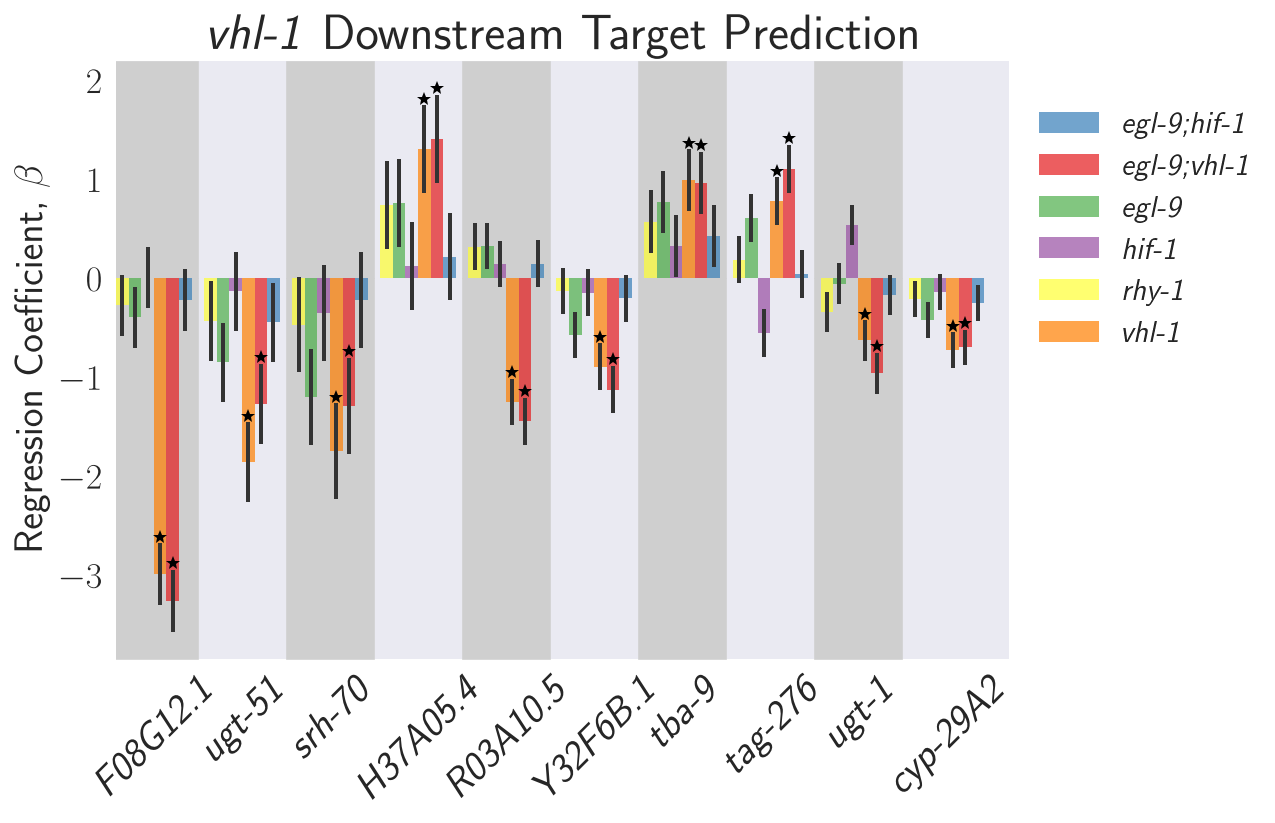

In [356]:
qPCR_plot(tidy, plot_order, color, clustering='genotype', plotting_group='target_id',
          title='\emph{vhl-1} Downstream Target Prediction', rotation=45)

# Core Hypoxia Response

In [54]:
# select all the genes that are stat. sig. with the exception
# of the egl-9;hif-1 suppressor
ind = ((df1.q_c < 0.1) & (df1.q_e < 0.1) &
      (df1.q_b < 0.1) & (df1.q_a < 0.1) &
       (df1.q_d < 0.1))
y = df1[ind].copy()
y.shape

(55, 32)

In [48]:
y_bs = df1[ind][['ens_gene', 'b_e', 'b_b', 'b_d', 'b_c', 'b', 'b_a']]
all_down = y_bs[y_bs<0].dropna().index
s = 'Number of genes that go down: {0}'
message = s.format(len(all_down))
print(message)

Number of genes that go down: 13


In [50]:
cols = ['ext_gene', 'ens_gene', 
        'b_e', 'b_b', 'b_d', 'b_c', 'b_a',
        'q_e', 'q_b', 'q_d', 'q_c', 'q_a']
sel = df1.ens_gene.isin(y_bs[y_bs<0].dropna().ens_gene)
all_down = df1[(sel)][cols].sort_values('q_a')

In [53]:
all_up = y_bs[y_bs>0].dropna().index
s = 'Number of genes that go up: {0}'
message = s.format(len(all_up))
print(message)

cols = ['ext_gene', 'ens_gene', 
        'b_e', 'b_b', 'b_d', 'b_c', 'b_a',
        'q_e', 'q_b', 'q_d', 'q_c', 'q_a']
all_up = df1[df1.index.isin(all_up)][cols].sort_values('q_a')

Number of genes that go up: 23


In [55]:
ids = all_up.ens_gene
_ = tea.enrichment_analysis(ids, tissue_df, show=True)
_ = tea.enrichment_analysis(ids, phenotype_df, show=True)
_ = tea.enrichment_analysis(ids, go_df, show=False)

Executing script

Analysis returned no enriched tissues.
Executing script

Analysis returned no enriched tissues.
